In [23]:
# Parameters
params = {
    "components_names": ["Pinene", "Benzyl benzoate"],
    "protons_list": [16, 12],
    "mix_filename": "preprocessed_mix.csv",
    "components_filenames": ["preprocessed_comp0.csv", "preprocessed_comp1.csv"],
    "N_signif_features_mix": 2000,
    "N_signif_features_comp": 1000,
    "md_lr": 10,
    "md_T": 50,
    "md_C": 15,
    "md_reg": 1.5,
    "md_reg_m1": 48.2,
    "md_reg_m2": 1,
    "md_damp": 1.0,
    "md_numIter": 1000,
    "md_step": 0.001,
    "eps": 1e-3,
}


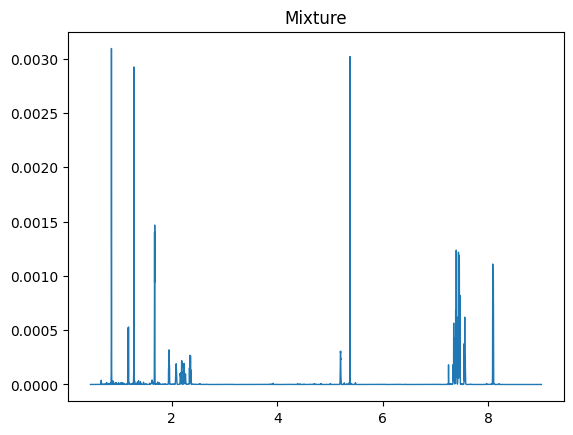

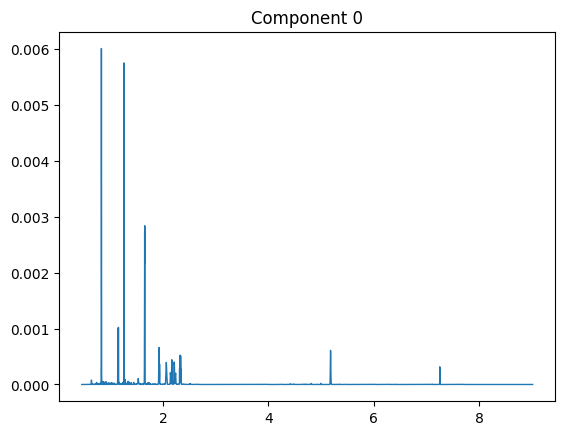

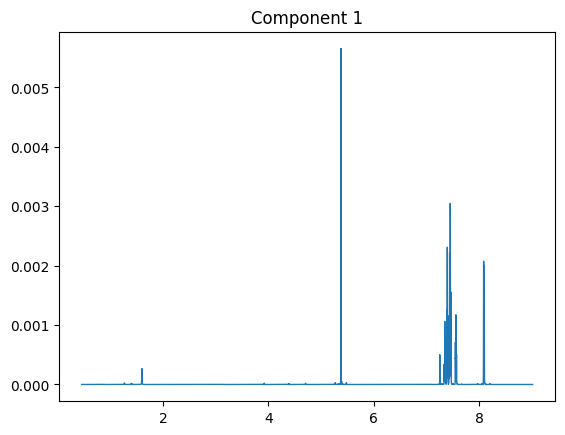

[(np.float64(0.457009), np.float64(1.528229306820996e-07)), (np.float64(0.457131), np.float64(1.2123352302240056e-07)), (np.float64(0.457253), np.float64(1.1059162033064253e-07)), (np.float64(0.457374), np.float64(9.99725490432446e-08)), (np.float64(0.457496), np.float64(9.365442068531171e-08)), (np.float64(0.457618), np.float64(8.733629232737883e-08)), (np.float64(0.457739), np.float64(1.2403407244641448e-07)), (np.float64(0.457861), np.float64(1.6073185256545014e-07)), (np.float64(0.457982), np.float64(2.3614336410202387e-07)), (np.float64(0.458104), np.float64(2.427302242599255e-07))]


In [24]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from wasserstein import Spectrum, NMRSpectrum

# Import sparse utilities
sys.path.append(os.path.abspath("."))
from test_utils import (
    UtilsSparse, 
    multidiagonal_cost, 
    warmstart_sparse, 
    reg_distribiution,
    signif_features,
)

from typing import List
from matplotlib import pyplot as plt

import numpy as np
from tqdm import trange

components_names = params["components_names"]

protons_list = params["protons_list"]

filename = params["mix_filename"]
mix = np.loadtxt(filename, delimiter=",")
# If you are using file exported from Mnova, comment line above and uncomment line below.
# mix = np.loadtxt(filename, delimiter='\t', usecols=[0,1])

how_many_components = len(components_names)
names = ["comp" + str(i) for i in range(how_many_components)]

files_with_components = params["components_filenames"]
spectra = []
for i in range(how_many_components):
    filename = files_with_components[i]
    spectra.append(np.loadtxt(filename, delimiter=","))
    # If you are using file exported from Mnova, comment line above and uncomment line below.
    # spectra.append(np.loadtxt(filename, delimiter='\t', usecols=[0,1]))

spectra2: List[NMRSpectrum] = []
names = []
for i in range(len(spectra)):
    spectra2.append(
        NMRSpectrum(
            confs=list(zip(spectra[i][:, 0], spectra[i][:, 1])), protons=protons_list[i]
        )
    )
    names.append("comp" + str(i))

spectra = spectra2
del spectra2
mix = NMRSpectrum(confs=list(zip(mix[:, 0], mix[:, 1])))
mix.trim_negative_intensities()
mix.normalize()
for sp in spectra:
    sp.trim_negative_intensities()
    sp.normalize()
plt.title("Mixture")
mix.plot(profile=True)
for i, sp in enumerate(spectra):
    plt.title("Component " + str(i))
    sp.plot(profile=True)
print(spectra[0].confs[:10])


In [ ]:
from scipy.sparse import dia_matrix
from concurrent.futures import ThreadPoolExecutor


def loss_sparse(
    mix, sp, C, reg, reg_m1, reg_m2, damp, numIter=1000, step=0.001, warmstart=None
):
    # extract marginals & locations
    a = np.array([pi for _, pi in mix.confs])
    v1 = np.array([v for v, _ in mix.confs])
    b = np.array([pi for _, pi in sp.confs])
    v2 = np.array([v for v, _ in sp.confs])

    # cost & reference
    M = multidiagonal_cost(v1, v2, C)
    if warmstart is None:
        warmstart = warmstart_sparse(a, b, C)
    c = reg_distribiution(len(mix.confs), C)

    # run sparse mirror‐descent
    sparse = UtilsSparse(a, b, c, warmstart, M, reg, reg_m1, reg_m2)
    G, log = sparse.mirror_descent_unbalanced(
        numItermax=numIter, step_size=step, gamma=1.0 - (20.0 / 1000.0)
    )

    # rebuild the full objective
    transport_cost = sparse.sparse_dot(G, sparse.offsets)
    marginal_penalty = sparse.marg_tv_sparse(G, sparse.offsets)
    final_dist = transport_cost + marginal_penalty / (reg_m1 + reg_m2) * damp

    # return distance _and_ the padded‐diagonals for warm‐starting next time
    return final_dist, G


def mirror_descent_two_weights_sparse(
    mix,
    comp0,
    comp1,
):
    # pick out your peaks just once
    C = params['md_C']
    N_mix = len(mix.confs)
    offsets = np.arange(-C + 1, C)
    matrix_shape = (N_mix, N_mix)

    p = np.array([0.5, 0.5])
    hist = [p.copy()]
    scores = []

    # no warmstart on the first call
    warm = None

    T = params['md_T']
    lr = params['md_lr']
    for i in trange(T, desc="Sparse MD (2 weights)"):
        print(f"Iteration {i+1}/{T}, current weights p={p}")
        # build current mix
        sp = Spectrum.ScalarProduct([comp0, comp1], p)
        sp.normalize()

        # 1) solve & get back the padded‐diagonals G_data
        dist, G_data = loss_sparse(
            mix,
            sp,
            params['md_C'],
            params['md_reg'],
            params['md_reg_m1'],
            params['md_reg_m2'],
            params['md_damp'],
            numIter=params['md_numIter'],
            step=params['md_step'],
            warmstart=warm,
        )
        scores.append(dist)
        print(f"Iteration {i+1}/{T}, distance={dist}")

        # 2) rebuild warmstart as a dia_matrix for next iteration
        warm = dia_matrix((G_data, offsets), shape=matrix_shape)

        # 3) finite‐difference gradient
        eps = params['eps']
        p_plus = np.clip([p[0] + eps, p[1] - eps], 1e-6, 1)
        p_plus /= p_plus.sum()
        p_minus = np.clip([p[0] - eps, p[1] + eps], 1e-6, 1)
        p_minus /= p_minus.sum()

        # two solves _with_ warm restart
        sp_p = Spectrum.ScalarProduct([comp0, comp1], p_plus)
        sp_p.normalize()
        sp_m = Spectrum.ScalarProduct([comp0, comp1], p_minus)
        sp_m.normalize()

        loss_args = (
            params['md_C'],
            params['md_reg'],
            params['md_reg_m1'],
            params['md_reg_m2'],
            params['md_damp'],
        )
        loss_kwargs = {
            "numIter": params['md_numIter'],
            "step": params['md_step'],
            "warmstart": warm,
        }
        
        with ThreadPoolExecutor(max_workers=2) as executor:
            future_p = executor.submit(loss_sparse, mix, sp_p, *loss_args, **loss_kwargs)
            future_m = executor.submit(loss_sparse, mix, sp_m, *loss_args, **loss_kwargs)
            Lp, _ = future_p.result()
            Lm, _ = future_m.result()

        g = (Lp - Lm) / (2 * eps)
        print(f"Iteration {i+1}/{T}, gradient g={g}")


        w = p * np.exp(-lr * np.array([g, -g]))
        p = w / w.sum()

        hist.append(p.copy())
    
    print("Finished mirror descent.")
    return p, np.array(hist), np.array(scores)


N = params['N_signif_features_comp']
spectra_signif = [None] * 2
spectra_signif[0] = signif_features(spectra[0], N)
spectra_signif[1] = signif_features(spectra[1], N)
mix_signif = signif_features(mix, params['N_signif_features_mix'])


final_p, traj, score_history = mirror_descent_two_weights_sparse(
    mix_signif, spectra_signif[0], spectra_signif[1]
)


Sparse MD (2 weights):   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1/50, current weights p=[0.5 0.5]
Iteration 1/50, distance=0.08256450557730738
Iteration 1/50, distance=0.08256450557730738


Sparse MD (2 weights):   2%|▏         | 1/50 [00:19<16:02, 19.64s/it]

Iteration 1/50, gradient g=0.0009009496448192378
Iteration 2/50, current weights p=[0.49549537 0.50450463]
Iteration 2/50, distance=0.0824990134499037
Iteration 2/50, distance=0.0824990134499037


Sparse MD (2 weights):   4%|▍         | 2/50 [00:38<15:26, 19.29s/it]

Iteration 2/50, gradient g=0.0008682508747942519
Iteration 3/50, current weights p=[0.49115492 0.50884508]
Iteration 3/50, distance=0.08244144874631186
Iteration 3/50, distance=0.08244144874631186


Sparse MD (2 weights):   6%|▌         | 3/50 [00:59<15:31, 19.83s/it]

Iteration 3/50, gradient g=0.0007470448912874628
Iteration 4/50, current weights p=[0.48742143 0.51257857]
Iteration 4/50, distance=0.08239047647239571
Iteration 4/50, distance=0.08239047647239571


Sparse MD (2 weights):   8%|▊         | 4/50 [01:19<15:17, 19.94s/it]

Iteration 4/50, gradient g=0.0018759492284373125
Iteration 5/50, current weights p=[0.47805314 0.52194686]
Iteration 5/50, distance=0.0823376400302855
Iteration 5/50, distance=0.0823376400302855


Sparse MD (2 weights):  10%|█         | 5/50 [01:38<14:43, 19.64s/it]

Iteration 5/50, gradient g=-0.001554880903996414
Iteration 6/50, current weights p=[0.48581724 0.51418276]
Iteration 6/50, distance=0.0823059077805838
Iteration 6/50, distance=0.0823059077805838


Sparse MD (2 weights):  12%|█▏        | 6/50 [01:57<14:18, 19.52s/it]

Iteration 6/50, gradient g=-0.000541363306863496
Iteration 7/50, current weights p=[0.48852226 0.51147774]
Iteration 7/50, distance=0.08227239948459154
Iteration 7/50, distance=0.08227239948459154


Sparse MD (2 weights):  14%|█▍        | 7/50 [02:18<14:12, 19.81s/it]

Iteration 7/50, gradient g=0.00214635254059542
Iteration 8/50, current weights p=[0.47780308 0.52219692]
Iteration 8/50, distance=0.0822226749800593
Iteration 8/50, distance=0.0822226749800593


Sparse MD (2 weights):  16%|█▌        | 8/50 [02:38<13:56, 19.92s/it]

Iteration 8/50, gradient g=0.0017293867810783126
Iteration 9/50, current weights p=[0.46918067 0.53081933]
Iteration 9/50, distance=0.08219089677319143
Iteration 9/50, distance=0.08219089677319143


Sparse MD (2 weights):  18%|█▊        | 9/50 [02:56<13:21, 19.54s/it]

Iteration 9/50, gradient g=0.003180460344982816
Iteration 10/50, current weights p=[0.4533751 0.5466249]
Iteration 10/50, distance=0.08215749985797086
Iteration 10/50, distance=0.08215749985797086


Sparse MD (2 weights):  20%|██        | 10/50 [03:16<13:03, 19.59s/it]

Iteration 10/50, gradient g=0.0008990178809314964
Iteration 11/50, current weights p=[0.44892295 0.55107705]
Iteration 11/50, distance=0.08213062637467339
Iteration 11/50, distance=0.08213062637467339


Sparse MD (2 weights):  22%|██▏       | 11/50 [03:36<12:42, 19.55s/it]

Iteration 11/50, gradient g=-0.0016479748945127937
Iteration 12/50, current weights p=[0.45708985 0.54291015]
Iteration 12/50, distance=0.08210503098878767
Iteration 12/50, distance=0.08210503098878767


Sparse MD (2 weights):  24%|██▍       | 12/50 [03:55<12:18, 19.45s/it]

Iteration 12/50, gradient g=-0.0018875240595864207
Iteration 13/50, current weights p=[0.46647204 0.53352796]
Iteration 13/50, distance=0.08207651991263187
Iteration 13/50, distance=0.08207651991263187


Sparse MD (2 weights):  26%|██▌       | 13/50 [04:15<12:04, 19.57s/it]

Iteration 13/50, gradient g=0.006981047855472711
Iteration 14/50, current weights p=[0.43194148 0.56805852]
Iteration 14/50, distance=0.08208737616139247
Iteration 14/50, distance=0.08208737616139247


Sparse MD (2 weights):  28%|██▊       | 14/50 [04:35<11:50, 19.74s/it]

Iteration 14/50, gradient g=-0.0031273954766986023
Iteration 15/50, current weights p=[0.4473493 0.5526507]
Iteration 15/50, distance=0.08201380906950381
Iteration 15/50, distance=0.08201380906950381


Sparse MD (2 weights):  30%|███       | 15/50 [04:54<11:27, 19.65s/it]

Iteration 15/50, gradient g=-0.0030228324712430754
Iteration 16/50, current weights p=[0.46233902 0.53766098]
Iteration 16/50, distance=0.08194513367316089
Iteration 16/50, distance=0.08194513367316089


Sparse MD (2 weights):  32%|███▏      | 16/50 [05:14<11:07, 19.63s/it]

Iteration 16/50, gradient g=-0.00336959335352216
Iteration 17/50, current weights p=[0.47912766 0.52087234]
Iteration 17/50, distance=0.08187398593666487
Iteration 17/50, distance=0.08187398593666487


Sparse MD (2 weights):  34%|███▍      | 17/50 [05:33<10:46, 19.59s/it]

Iteration 17/50, gradient g=0.0007981854298899638
Iteration 18/50, current weights p=[0.4751451 0.5248549]
Iteration 18/50, distance=0.08172663382000078
Iteration 18/50, distance=0.08172663382000078


Sparse MD (2 weights):  36%|███▌      | 18/50 [05:52<10:15, 19.24s/it]

Iteration 18/50, gradient g=-0.004299420630085593
Iteration 19/50, current weights p=[0.49662175 0.50337825]
Iteration 19/50, distance=0.08155328257742657
Iteration 19/50, distance=0.08155328257742657


Sparse MD (2 weights):  38%|███▊      | 19/50 [06:12<10:07, 19.60s/it]

Iteration 19/50, gradient g=0.0032745514234600037
Iteration 20/50, current weights p=[0.48025921 0.51974079]
Iteration 20/50, distance=0.08122229297827437
Iteration 20/50, distance=0.08122229297827437


Sparse MD (2 weights):  40%|████      | 20/50 [06:32<09:48, 19.62s/it]

Iteration 20/50, gradient g=0.002649690999445564
Iteration 21/50, current weights p=[0.46704832 0.53295168]
Iteration 21/50, distance=0.08082148771489958
Iteration 21/50, distance=0.08082148771489958


Sparse MD (2 weights):  42%|████▏     | 21/50 [06:52<09:34, 19.82s/it]

Iteration 21/50, gradient g=-0.0009417175328430005
Iteration 22/50, current weights p=[0.47173923 0.52826077]
Iteration 22/50, distance=0.08034318740837404
Iteration 22/50, distance=0.08034318740837404


Sparse MD (2 weights):  44%|████▍     | 22/50 [07:13<09:23, 20.14s/it]

Iteration 22/50, gradient g=0.0009734909995340324
Iteration 23/50, current weights p=[0.46689014 0.53310986]
Iteration 23/50, distance=0.07979187347206336
Iteration 23/50, distance=0.07979187347206336


Sparse MD (2 weights):  46%|████▌     | 23/50 [07:33<09:06, 20.24s/it]

Iteration 23/50, gradient g=6.096576981445834e-05
Iteration 24/50, current weights p=[0.46658666 0.53341334]
Iteration 24/50, distance=0.07917675244073655
Iteration 24/50, distance=0.07917675244073655


Sparse MD (2 weights):  48%|████▊     | 24/50 [07:54<08:51, 20.44s/it]

Iteration 24/50, gradient g=0.004232153596774035
Iteration 25/50, current weights p=[0.4455923 0.5544077]
Iteration 25/50, distance=0.07859606139181277
Iteration 25/50, distance=0.07859606139181277


Sparse MD (2 weights):  50%|█████     | 25/50 [08:16<08:36, 20.64s/it]

Iteration 25/50, gradient g=-0.0002806481944062078
Iteration 26/50, current weights p=[0.44697935 0.55302065]
Iteration 26/50, distance=0.07796599695826338
Iteration 26/50, distance=0.07796599695826338


Sparse MD (2 weights):  52%|█████▏    | 26/50 [08:37<08:21, 20.88s/it]

Iteration 26/50, gradient g=0.0031464548938542336
Iteration 27/50, current weights p=[0.43148081 0.56851919]
Iteration 27/50, distance=0.07744487785967305
Iteration 27/50, distance=0.07744487785967305


Sparse MD (2 weights):  54%|█████▍    | 27/50 [08:58<08:03, 21.01s/it]

Iteration 27/50, gradient g=-0.003126737595116058
Iteration 28/50, current weights p=[0.44688187 0.55311813]
Iteration 28/50, distance=0.07690347741890853
Iteration 28/50, distance=0.07690347741890853


Sparse MD (2 weights):  56%|█████▌    | 28/50 [09:20<07:45, 21.17s/it]

Iteration 28/50, gradient g=0.003174081792955974
Iteration 29/50, current weights p=[0.43124855 0.56875145]
Iteration 29/50, distance=0.07645433224930133
Iteration 29/50, distance=0.07645433224930133


Sparse MD (2 weights):  58%|█████▊    | 29/50 [09:41<07:23, 21.12s/it]

Iteration 29/50, gradient g=0.00014919439540045376
Iteration 30/50, current weights p=[0.43051683 0.56948317]
Iteration 30/50, distance=0.07605657830350283
Iteration 30/50, distance=0.07605657830350283


Sparse MD (2 weights):  60%|██████    | 30/50 [10:02<07:04, 21.20s/it]

Iteration 30/50, gradient g=0.002820919849072512
Iteration 31/50, current weights p=[0.41674226 0.58325774]
Iteration 31/50, distance=0.07574310788565378
Iteration 31/50, distance=0.07574310788565378


Sparse MD (2 weights):  62%|██████▏   | 31/50 [10:24<06:48, 21.47s/it]

Iteration 31/50, gradient g=0.004086276570024194
Iteration 32/50, current weights p=[0.39702254 0.60297746]
Iteration 32/50, distance=0.07564534368414194
Iteration 32/50, distance=0.07564534368414194


Sparse MD (2 weights):  64%|██████▍   | 32/50 [10:46<06:29, 21.65s/it]

Iteration 32/50, gradient g=-0.01373816649853643
Iteration 33/50, current weights p=[0.4642801 0.5357199]
Iteration 33/50, distance=0.07560960938396465
Iteration 33/50, distance=0.07560960938396465



Final weights:
  comp1 = 0.9047
  comp2 = 0.0953


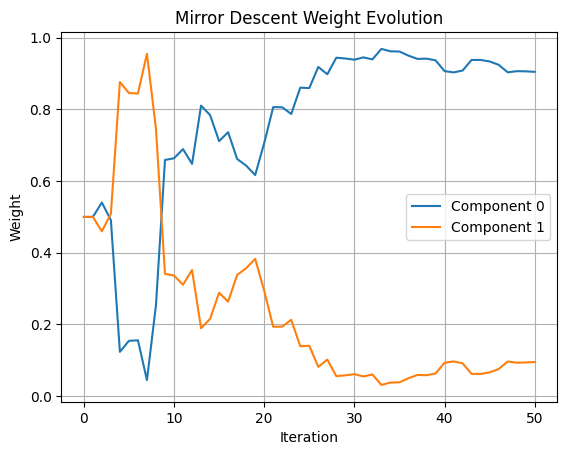

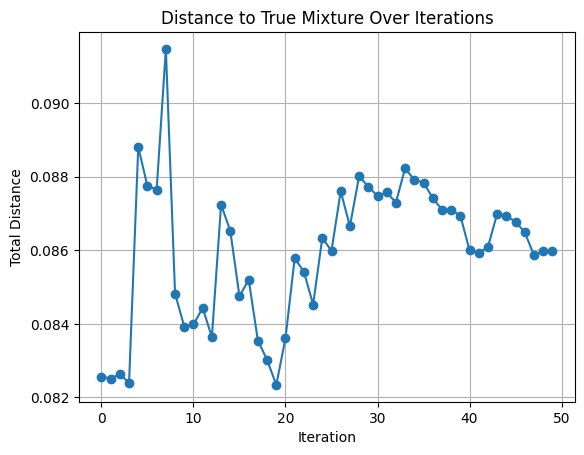

In [ ]:
print("\nFinal weights:")
print(f"  comp1 = {final_p[0]:.4f}")
print(f"  comp2 = {final_p[1]:.4f}")

plt.plot(traj[:, 0], label="Component 0")
plt.plot(traj[:, 1], label="Component 1")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.title("Mirror Descent Weight Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(score_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Total Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()
